In [285]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import json
import pandas as pd
import os
import sys
import glob
import unicodedata
from sklearn.externals import joblib
from sklearn import model_selection, preprocessing, metrics, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import decomposition, ensemble


from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

# set up display area to show dataframe in jupyter qtconsole
pd.set_option('display.max_colwidth', 150)

%matplotlib inline

In [2]:
favorites = []
user_id = []
tweet_id = []
retweet = []
tweet = []
date = []


directories = ['Corruption/Bfr elec 1_jan_to_6_apr', 'Corruption/Electn time 7_aprl_to_12_may', 'Corruption/Aftr elctn 13_may_to_31_aug',
           'Development/before 1_jan_to_6_april', 'Development/elec 7_apr_to_12_may', 'Development/after 13_may_to_31_aug',
           'India Economy/Bfr elec 1_jan_to_6_apr', 'India Economy/Electn time 7_aprl_to_12_may', 'India Economy/Aftr elctn 13_may_to_31_aug']


def json2csv(data_obj):
    for key in data_obj:
        favorites.append(key['favorites'])
        user_id.append(key['user_id'])
        tweet_id.append(key['tweet_id'])
        retweet.append(key['retweet'])
        tweet.append(key['tweet'])
        date.append(key['date'])
    df = pd.DataFrame({'favorites': favorites, 'user_id': user_id, 'tweet_id': tweet_id, 'retweet': retweet, 'tweet': tweet, 'date': date})
    df.to_csv('data.csv', encoding='utf-8', index=False)


def get_file_path(directories):  
    root_dir = os.path.abspath('.')
    files = []
    
    for dirs in directories:
        data_dir = os.path.join(root_dir, dirs)
        path = os.path.join(data_dir, '*.json')
        files.extend(glob.glob(path))
    return files


def build_csv(directories):
    for file in get_file_path(directories):
        try:
            with open(file, mode='r') as f:
                data_json = f.read()
                data_obj = json.loads(data_json)
                json2csv(data_obj)
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise

In [3]:
build_csv(directories)

In [211]:
train_df = pd.read_csv('data.csv')

In [212]:
train_df.head()

,favorites,user_id,tweet_id,retweet,tweet,date
0,1,221463601,418467053238894592,7,@ minhazmerchant sir Arvind Kejriwal Denies Sheila Dixit Corruption https://www.youtube.com/watch?v=EVKFYiK9F0M#t18= … … … # AAPcon every india sh...,2014-01-02 01:11:34
1,5,315928198,418452683154923521,6,"# AAP is attracting India Inc,due to its zeal to fight corruption,initiatives to simplify system & ability to bring in a global perspective.",2014-01-02 00:14:28
2,4,901945033,418435358842310658,9,Took 17yrs for Corey Anderson to beat Shahid Afridi's ODI ton - - Am Sure None Can Beat Congress' Corruption Record in India Even Aft 100yrs,2014-01-01 23:05:38
3,1,18237781,418430142428368896,2,"# India # AAP # Delhi # Corruption Has @ ArvindKejriwal compromised his anti-corruption stance due to compulsions of ""outside support politics"" ?",2014-01-01 22:44:54
4,17,1376312424,418408312556621827,51,"Hurry Up Guys, take AAP membership soon, offer valid till corruption exists in India. # TrustVote4AAP http://www.aamaadmiparty.org/join-us",2014-01-01 21:18:10


In [213]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31034 entries, 0 to 31033
Data columns (total 6 columns):
favorites    31034 non-null int64
user_id      31034 non-null int64
tweet_id     31034 non-null int64
retweet      31034 non-null int64
tweet        31034 non-null object
date         31034 non-null object
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


In [214]:
# removing the user handler like "@ bloombergnews"

def remove_handler(input_txt):
    pattern = "@\s?[\w]*"
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt


train_df['tidy_tweet'] = np.vectorize(remove_handler)(train_df['tweet'])      

In [215]:
#converting é to e accented characters/letters

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


train_df['tidy_tweet'] = np.vectorize(remove_accented_chars)(train_df['tidy_tweet'])

In [216]:
#Converting each contraction to its expanded, original form helps with text standardization.

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

train_df['tidy_tweet'] = np.vectorize(expand_contractions)(train_df['tidy_tweet'])

In [217]:
# Remove http/https url tags

def remove_url(input_txt):
    pattern = 'http[s]?://\S+|pic.twitter.\S+|twitter.\S+'
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = input_txt.replace(i, '', 1)
    return input_txt

train_df['tidy_tweet'] = np.vectorize(remove_url)(train_df['tidy_tweet'])

In [218]:
train_df['tidy_tweet'] = train_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [219]:
# Removing redudant space after hashtag just to make whole hashtag as a single token

def remove_hash_space(input_txt):
    pattern = '#\s+'
    input_txt = re.sub(pattern, '#', input_txt)
    return input_txt

train_df['tidy_tweet'] = np.vectorize(remove_hash_space)(train_df['tidy_tweet']) 

In [220]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

train_df['tidy_tweet'] = np.vectorize(remove_stopwords)(train_df['tidy_tweet'])

In [221]:
def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

train_df['tidy_tweet'] = np.vectorize(stemmer)(train_df['tidy_tweet'])

In [222]:
train_df.head()

,favorites,user_id,tweet_id,retweet,tweet,date,tidy_tweet
0,1,221463601,418467053238894592,7,@ minhazmerchant sir Arvind Kejriwal Denies Sheila Dixit Corruption https://www.youtube.com/watch?v=EVKFYiK9F0M#t18= … … … # AAPcon every india sh...,2014-01-02 01:11:34,sir arvind kejriw deni sheila dixit corrupt #aapcon everi india watch video
1,5,315928198,418452683154923521,6,"# AAP is attracting India Inc,due to its zeal to fight corruption,initiatives to simplify system & ability to bring in a global perspective.",2014-01-02 00:14:28,#aap attract india inc due zeal fight corrupt initi simplifi system abil bring global perspect
2,4,901945033,418435358842310658,9,Took 17yrs for Corey Anderson to beat Shahid Afridi's ODI ton - - Am Sure None Can Beat Congress' Corruption Record in India Even Aft 100yrs,2014-01-01 23:05:38,took yr corey anderson beat shahid afridi odi ton sure none beat congress corrupt record india even aft yr
3,1,18237781,418430142428368896,2,"# India # AAP # Delhi # Corruption Has @ ArvindKejriwal compromised his anti-corruption stance due to compulsions of ""outside support politics"" ?",2014-01-01 22:44:54,#india #aap #delhi #corrupt compromis anti corrupt stanc due compuls outsid support polit
4,17,1376312424,418408312556621827,51,"Hurry Up Guys, take AAP membership soon, offer valid till corruption exists in India. # TrustVote4AAP http://www.aamaadmiparty.org/join-us",2014-01-01 21:18:10,hurri guy take aap membership soon offer valid till corrupt exist india #trustvot aap


In [223]:
r = re.compile('\w+aap\w+|\w+aap|aap\w+|aap|\w+aam\w+|\w+aam|aam\w+|\w+arvind\w+|\w+arvind|arvind\w+|arvind|\w+kejri\w+|\w+kejri|kejri\w+|kejri|\w+askkejri\w+|\w+askkejri|askkejri\w+|askkejri|akasksmodi|akdelhijansabha|akin\w+|aravindkejiriw|arwind|\w+lokp\w+|\w+lokp|lokp\w+|\w+jhaadu\w+|\w+jhaadu|jhaadu\w+|jhaddu')
for i in range(0, train_df['tidy_tweet'].count()):
    str = train_df['tidy_tweet'].iloc[i]
    ht = re.findall(r"#(\w+)", str)
    match = list(filter(r.match, ht))
    if not match:
        train_df.at[i, 'target'] = 'others'
    else:
        train_df.at[i, 'target'] = 'aap'

In [224]:
train_df.head()

,favorites,user_id,tweet_id,retweet,tweet,date,tidy_tweet,target
0,1,221463601,418467053238894592,7,@ minhazmerchant sir Arvind Kejriwal Denies Sheila Dixit Corruption https://www.youtube.com/watch?v=EVKFYiK9F0M#t18= … … … # AAPcon every india sh...,2014-01-02 01:11:34,sir arvind kejriw deni sheila dixit corrupt #aapcon everi india watch video,aap
1,5,315928198,418452683154923521,6,"# AAP is attracting India Inc,due to its zeal to fight corruption,initiatives to simplify system & ability to bring in a global perspective.",2014-01-02 00:14:28,#aap attract india inc due zeal fight corrupt initi simplifi system abil bring global perspect,aap
2,4,901945033,418435358842310658,9,Took 17yrs for Corey Anderson to beat Shahid Afridi's ODI ton - - Am Sure None Can Beat Congress' Corruption Record in India Even Aft 100yrs,2014-01-01 23:05:38,took yr corey anderson beat shahid afridi odi ton sure none beat congress corrupt record india even aft yr,others
3,1,18237781,418430142428368896,2,"# India # AAP # Delhi # Corruption Has @ ArvindKejriwal compromised his anti-corruption stance due to compulsions of ""outside support politics"" ?",2014-01-01 22:44:54,#india #aap #delhi #corrupt compromis anti corrupt stanc due compuls outsid support polit,aap
4,17,1376312424,418408312556621827,51,"Hurry Up Guys, take AAP membership soon, offer valid till corruption exists in India. # TrustVote4AAP http://www.aamaadmiparty.org/join-us",2014-01-01 21:18:10,hurri guy take aap membership soon offer valid till corrupt exist india #trustvot aap,others


In [225]:
r = re.compile('\w+modi\w+|\w+modi|modi\w+|modi|\w+namo\w+|\w+namo|namo\w+|namo|ach\w+|acch\w+|amitshah|\w+bjp\w+|\w+bjp|bjp\w+|bjp|bjd|askjaitley|\w+chaiwala\w+|\w+chaiwala|chaiwala\w+|chaiwala')
for i in range(0, train_df['tidy_tweet'].count()):
    if train_df.at[i, 'target'] == 'others':
        str = train_df['tidy_tweet'].iloc[i]
        ht = re.findall(r"#(\w+)", str)
        match = list(filter(r.match, ht))
        if not match:
            pass
        else:
            train_df.at[i, 'target'] = 'bjp'

In [226]:
r = re.compile('\w+congress\w+|\w+congress|congress\w+|congress|gandhi\w+|\w+gandhi|gandhi|\w+rahul\w+|\w+rahul|rahul\w+|rahul|rahulgandhi|pappu|agustawestland|feku\w+|feku|manmohansingh')
for i in range(0, train_df['tidy_tweet'].count()):
    if train_df.at[i, 'target'] == 'others':
        str = train_df['tidy_tweet'].iloc[i]
        ht = re.findall(r"#(\w+)", str)
        match = list(filter(r.match, ht))
        if not match:
            pass
        else:
            train_df.at[i, 'target'] = 'congress'

In [227]:
r = re.compile('aap\w+|aap|arvind\w+|arvind|kejri\w+|kejri|arwind')
for i in range(0, train_df['tidy_tweet'].count()):
    if train_df.at[i, 'target'] == 'others':
        str = train_df['tidy_tweet'].iloc[i]
        ht = re.findall(r, str)
        if not ht:
            pass
        else:
            train_df.at[i, 'target'] = 'aap'

In [228]:
r = re.compile('modi|namo|bjp')
for i in range(0, train_df['tidy_tweet'].count()):
    if train_df.at[i, 'target'] == 'others':
        str = train_df['tidy_tweet'].iloc[i]
        ht = re.findall(r, str)
        if not ht:
            pass
        else:
            train_df.at[i, 'target'] = 'bjp'

In [229]:
r = re.compile('congress|rahul|gandhi|sonia|\binc\b|\bupa\b')
for i in range(0, train_df['tidy_tweet'].count()):
    if train_df.at[i, 'target'] == 'others':
        str = train_df['tidy_tweet'].iloc[i]
        ht = re.findall(r, str)
        if not ht:
            pass
        else:
            train_df.at[i, 'target'] = 'congress'

In [230]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [231]:
train_df.head()

,favorites,user_id,tweet_id,retweet,tweet,date,tidy_tweet,target
0,1,221463601,418467053238894592,7,@ minhazmerchant sir Arvind Kejriwal Denies Sheila Dixit Corruption https://www.youtube.com/watch?v=EVKFYiK9F0M#t18= … … … # AAPcon every india sh...,2014-01-02 01:11:34,sir arvind kejriw deni sheila dixit corrupt #aapcon everi india watch video,aap
1,5,315928198,418452683154923521,6,"# AAP is attracting India Inc,due to its zeal to fight corruption,initiatives to simplify system & ability to bring in a global perspective.",2014-01-02 00:14:28,#aap attract india inc due zeal fight corrupt initi simplifi system abil bring global perspect,aap
2,4,901945033,418435358842310658,9,Took 17yrs for Corey Anderson to beat Shahid Afridi's ODI ton - - Am Sure None Can Beat Congress' Corruption Record in India Even Aft 100yrs,2014-01-01 23:05:38,took yr corey anderson beat shahid afridi odi ton sure none beat congress corrupt record india even aft yr,congress
3,1,18237781,418430142428368896,2,"# India # AAP # Delhi # Corruption Has @ ArvindKejriwal compromised his anti-corruption stance due to compulsions of ""outside support politics"" ?",2014-01-01 22:44:54,#india #aap #delhi #corrupt compromis anti corrupt stanc due compuls outsid support polit,aap
4,17,1376312424,418408312556621827,51,"Hurry Up Guys, take AAP membership soon, offer valid till corruption exists in India. # TrustVote4AAP http://www.aamaadmiparty.org/join-us",2014-01-01 21:18:10,hurri guy take aap membership soon offer valid till corrupt exist india #trustvot aap,aap


In [232]:
data= train_df.loc[:, ['tidy_tweet']]

In [233]:
data['month'] = pd.DatetimeIndex(train_df['date']).month

In [234]:
import calendar
data['month'] = data['month'].apply(lambda x: calendar.month_abbr[x])

In [235]:
data.head()

,tidy_tweet,month
0,sir arvind kejriw deni sheila dixit corrupt #aapcon everi india watch video,Jan
1,#aap attract india inc due zeal fight corrupt initi simplifi system abil bring global perspect,Jan
2,took yr corey anderson beat shahid afridi odi ton sure none beat congress corrupt record india even aft yr,Jan
3,#india #aap #delhi #corrupt compromis anti corrupt stanc due compuls outsid support polit,Jan
4,hurri guy take aap membership soon offer valid till corrupt exist india #trustvot aap,Jan


In [236]:
monthly = data.groupby(by=['month'], sort=True)['tidy_tweet'].count()

In [238]:
monthly = pd.DataFrame(({'month': monthly.index, 'count': monthly.values}))

In [240]:
monthly

,month,count
0,Apr,4687
1,Aug,2538
2,Feb,3574
3,Jan,4071
4,Jul,3752
5,Jun,3654
6,Mar,3994
7,May,4752
8,Sep,12


In [242]:
monthly = monthly.set_index(monthly.month)

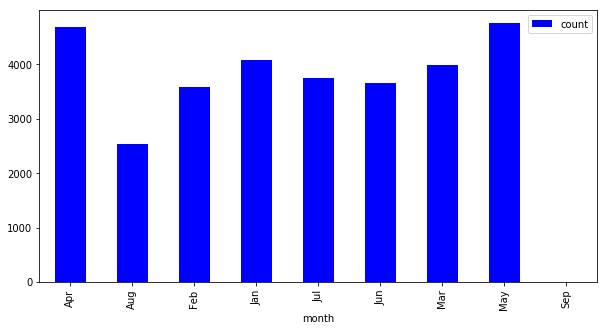

In [244]:
monthly.plot(kind='bar', figsize=(10, 5), color='blue');

In [245]:
data['hour'] = pd.DatetimeIndex(train_df['date']).hour

In [246]:
hourly = data.groupby(by=['hour'], sort=True)['tidy_tweet'].count()

In [248]:
hourly = pd.DataFrame(({'hour': hourly.index, 'count': hourly.values}))

In [251]:
hourly.drop(['hour'], axis=1, inplace=True)

In [252]:
hourly

,count
0,933
1,613
2,454
3,366
4,440
5,1097
6,1618
7,1957
8,1802
9,1780


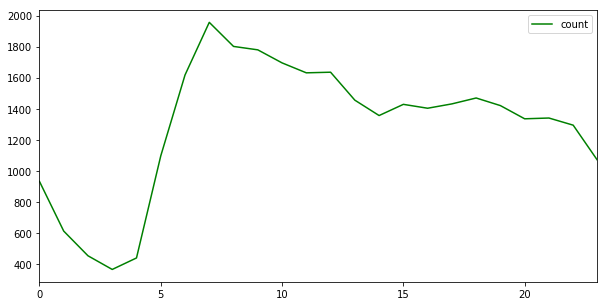

In [253]:
hourly.plot(figsize=(10, 5), color='green');

In [254]:
target = train_df[(train_df['target'] == 'aap') | (train_df['target'] == 'bjp') | (train_df['target'] == 'congress')]

In [255]:
target = target.groupby(['target']).count()

In [257]:
target.drop(['favorites', 'user_id', 'tweet_id', 'retweet', 'tweet', 'date'], axis=1, inplace=True)

In [260]:
target

,tidy_tweet
target,
aap,2290
bjp,4699
congress,893


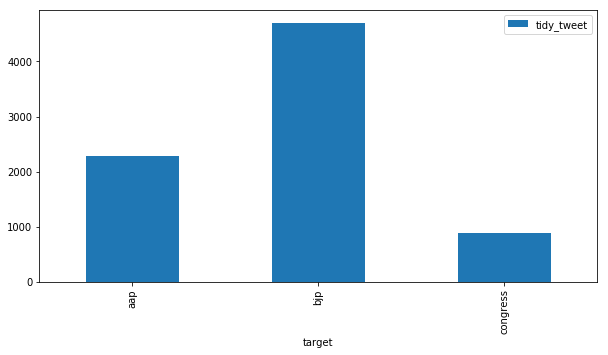

In [261]:
target.plot(kind='bar',figsize=(10, 5));

In [262]:
train_df['target'].value_counts()

others      23152
bjp          4699
aap          2290
congress      893
Name: target, dtype: int64

In [263]:
train_df.drop(train_df[train_df.target == 'others'].index[:-6000], inplace=True)

In [264]:
train_df[train_df['target'] == 'others'].count()

favorites     6000
user_id       6000
tweet_id      6000
retweet       6000
tweet         6000
date          6000
tidy_tweet    6000
target        6000
dtype: int64

In [265]:
train_df['target'].value_counts()

others      6000
bjp         4699
aap         2290
congress     893
Name: target, dtype: int64

In [266]:
train_df.drop(['favorites', 'user_id', 'tweet_id', 'retweet', 'tweet', 'date'], axis=1, inplace=True)

In [267]:
train_df.count()

tidy_tweet    13882
target        13882
dtype: int64

In [268]:
train_df.head()

,tidy_tweet,target
0,sir arvind kejriw deni sheila dixit corrupt #aapcon everi india watch video,aap
1,#aap attract india inc due zeal fight corrupt initi simplifi system abil bring global perspect,aap
2,took yr corey anderson beat shahid afridi odi ton sure none beat congress corrupt record india even aft yr,congress
3,#india #aap #delhi #corrupt compromis anti corrupt stanc due compuls outsid support polit,aap
4,hurri guy take aap membership soon offer valid till corrupt exist india #trustvot aap,aap


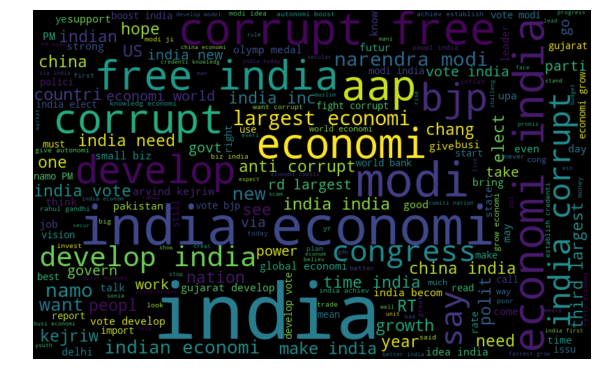

In [269]:
from wordcloud.wordcloud import WordCloud

words = ' '.join([text for text in train_df['tidy_tweet']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [270]:
train_df.head(2)

,tidy_tweet,target
0,sir arvind kejriw deni sheila dixit corrupt #aapcon everi india watch video,aap
1,#aap attract india inc due zeal fight corrupt initi simplifi system abil bring global perspect,aap


In [271]:
# split the dataset into training and validation datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(train_df['tidy_tweet'], train_df['target'], test_size=0.20, random_state=100, shuffle=True) # 80% Train and 20% Test split


In [272]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

### Feature Extraction - TFIDF

In [273]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'#?\w{1,}', max_features=len(train_x))
tfidf_vect.fit(train_df['tidy_tweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

### Model

In [274]:
# Setup training model and make prediction

def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net=False):
    
    # fit the training dataset on the classifier
    
    classifier.fit(feature_vector_train, label)
    joblib.dump(classifier,'ml_clf_model.pkl')
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, test_y)

### Naive Bayes

In [281]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xtest_tfidf)
print("Naive Bayes, WordLevel TF-IDF: ", accuracy)

Naive Bayes, WordLevel TF-IDF:  0.8167086784299604


### XGboost

In [ ]:
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xtest_tfidf.tocsc())
print("Xgboost, WordLevel TF-IDF: ", accuracy)

### Random Forest

In [282]:
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xtest_tfidf)
print("Random Forest, WordLevel TF-IDF: ", accuracy)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest, WordLevel TF-IDF:  0.9312207418077062


### Word Embedding

In [ ]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import io
# load the pre-trained word-embedding vectors 

embeddings_index = {}
for i, line in enumerate(io.open('wiki-news-300d-1M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
tokenizer.tokenize(text)
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(train_df['tidy_tweet'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Neural Network LSTM

In [ ]:
def create_rnn_lstm(): 
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print("RNN-LSTM, Word Embeddings",  accuracy)

### Validation

In [38]:
# Validating our model

def clean_tweet(tweet):
    tweet = remove_handler(tweet)
    tweet = remove_accented_chars(tweet)
    tweet = expand_contractions(tweet)
    tweet = remove_url(tweet)
    tweet = re.sub("[^a-zA-Z#]", " ", tweet)
    tweet = remove_hash_space(tweet)
    tweet = remove_stopwords(tweet)
    tweet = stemmer(tweet)
    return tweet


def get_pred(norm_tweet):
    clf = joblib.load('clf_model.pkl')
    label = clf.predict(tfidf_vect.transform([norm_tweet]))
    if label == 0:
        pred = 'AAP'
    elif label == 1:
        pred = 'BJP'
    elif label == 2:
        pred = 'Congress'
    else:
        pred = 'Others'
    return pred

tweet = input("Enter Tweet: ")

norm_tweet = clean_tweet(tweet)
result = get_pred(norm_tweet)
df = pd.DataFrame([tweet, result]).T
df.columns = ['Tweet', 'Party']
print(df)

Enter Tweet: What are you doing?
                 Tweet   Party
0  What are you doing?  Others


### Sentiment Analysis

In [44]:
from textblob import TextBlob
sentiment_scores_tb = [round(TextBlob(text).sentiment.polarity, 3) for text in train_df['tidy_tweet']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

# sentiment statistics per tweet target
df = pd.DataFrame([list(train_df['tidy_tweet']), list(train_df['target']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['tidy_tweet', 'target', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['target']).describe()


sentiment_score                                                 
                   count      mean       std  min   25%   50%    75%  max
target                                                                   
aap               2290.0 -0.148248  0.266730 -1.0 -0.50 -0.05  0.000  1.0
bjp               4699.0  0.008588  0.300820 -1.0 -0.05  0.00  0.100  1.0
congress           893.0 -0.131571  0.271871 -0.8 -0.40  0.00  0.000  1.0
others            6000.0  0.040977  0.248900 -1.0  0.00  0.00  0.083  1.0

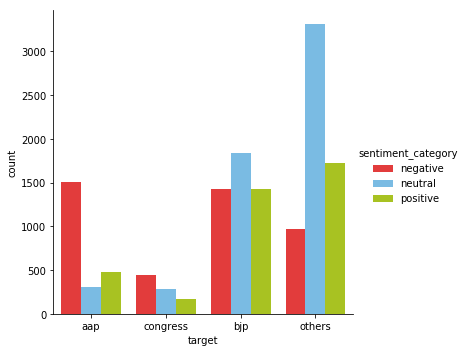

In [46]:
import seaborn as sns
fc = sns.catplot(x="target", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

### Extras

In [ ]:
r = re.compile('voiceofyouth')
for i in range(0, df['tidy_tweet'].count()):
    if df.at[i, 'target'] == 'others':
    str = df['tidy_tweet'].iloc[i]
    ht = re.findall(r, str)
    if not ht:
        pass
    else:    
        print(str)
        
    
 #   if not match:
 #       pass
 #   else:
 #       print(i,match)

In [242]:
clf = joblib.load('clf_model')

In [246]:
txt = "india corrupt #iac henc forward call #kfc kejriw corrupt #kfc good yummi yummi #aapcon #delhi"
len(re.findall("[^a-zA-Z#]", txt))

14

<1966x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 21525 stored elements in Compressed Sparse Row format>

In [ ]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

ht = hashtag_extract(df['tidy_tweet'])
ht = sum(ht,[])
ht_unq = set(ht)
ht_unq = list(ht_unq)
ht_unq.sort()

for i in ht_unq:
    r = '\w+modi\w+|\w+modi|modi\w+|modi|\w+namo\w+|\w+namo|namo\w+|namo|ach\w+|acch\w+|amitshah|\w+bjp\w+|\w+bjp|bjp\w+|bjp|bjd|askjaitley|\w+chaiwala\w+|\w+chaiwala|chaiwala\w+|chaiwala'
    x = re.search(r, i)
    if x == None:
        pass
    else:
        bjp.append(x.group(0))
        ht_unq.remove(i)